In [1]:
%env THEANO_FLAGS='device=gpu0','floatX=float32'

import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T
from lasagne import *

%matplotlib nbagg
import matplotlib.pyplot as plt

from mldm import NNWatcher, Net

env: THEANO_FLAGS='device=gpu0','floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [3]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [4]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [5]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [6]:
class CAE(Net):
    def __init__(self, n_codes=25):
        self.n_codes = n_codes
        X_batch = T.ftensor4(name='images')

        in_l = layers.InputLayer(shape=(None, 1, 28, 28), input_var=X_batch)
        
        drop1 = layers.DropoutLayer(in_l, p=0.25, rescale=False)
        
        conv1 = layers.Conv2DLayer(
            drop1,
            num_filters=16,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )
        pool1 = layers.Pool2DLayer(
            conv1,
            pool_size=(2, 2)
        )
        
        conv2 = layers.Conv2DLayer(
            pool1,
            num_filters=32,
            filter_size=(2, 2),
            nonlinearity=nonlinearities.elu
        )
        pool2 = layers.Pool2DLayer(
            conv2,
            pool_size=(2, 2)
        )
        
        conv3 = layers.Conv2DLayer(
            pool2,
            num_filters=64,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )
        pool3 = layers.Pool2DLayer(
            conv3,
            pool_size=(2, 2)
        )
        
        conv4 = layers.Conv2DLayer(
            pool3,
            filter_size=(2, 2),
            num_filters=128
        )
        
        flatten = layers.FlattenLayer(conv4)
        
        dense1 = layers.DenseLayer(
            flatten,
            num_units = n_codes,
            nonlinearity=nonlinearities.sigmoid
        )
        
        drop2 = layers.DropoutLayer(dense1, p=0.1)
        
        code = layers.get_output(dense1, deterministic=True)
        
        dense2 = layers.DenseLayer(
            drop2,
            num_units=128,
            nonlinearity=nonlinearities.sigmoid
        )
        
        dedense = layers.ReshapeLayer(
            dense2,
            shape=(-1, 128, 1, 1)
        )
        
        deconv1 = layers.Deconv2DLayer(
            dedense,
            num_filters=64,
            filter_size=(2, 2),
            crop='valid',
            nonlinearity=nonlinearities.elu
        )
        
        upscale1 = layers.Upscale2DLayer(
            deconv1,
            scale_factor=2
        )
        
        deconv2 = layers.Deconv2DLayer(
            upscale1,
            num_filters=32,
            filter_size=(3, 3),
            crop='valid',
            nonlinearity=nonlinearities.elu
        )
        
        upscale2 = layers.Upscale2DLayer(
            deconv2,
            scale_factor=2
        )
        
        deconv3 = layers.Deconv2DLayer(
            upscale2,
            num_filters=16,
            filter_size=(2, 2),
            crop='valid',
            nonlinearity=nonlinearities.elu
        )
        
        upscale3 = layers.Upscale2DLayer(
            deconv3,
            scale_factor=2
        )
        
        deconv4 = layers.Deconv2DLayer(
            upscale3,
            num_filters = 1,
            filter_size=(3, 3),
            crop='valid',
            nonlinearity=nonlinearities.sigmoid
        )
        
        self.net = deconv4
        
        X_reconstructed = layers.get_output(self.net)
        
        log_loss = -T.mean(X_batch * T.log(X_reconstructed) + (1 - X_batch) * T.log(1 - X_reconstructed))
        mse_loss = T.mean((X_reconstructed - X_batch) ** 2)
        
        params = layers.get_all_params(self.net)
        
        learning_rate = T.fscalar('learning rate')
        upd_log = updates.adadelta(log_loss, params, learning_rate=learning_rate)
        upd_mse = updates.adadelta(mse_loss, params, learning_rate=learning_rate)
        
        self.train_log = theano.function([X_batch, learning_rate], log_loss, updates=upd_log)
        self.train_mse = theano.function([X_batch, learning_rate], mse_loss, updates=upd_mse)
        
        self.encode = theano.function([X_batch], code)
        
        code_given = T.fmatrix('given code')
        X_decoded = layers.get_output(self.net, inputs={ dense1 : code_given }, deterministic=True)
        self.decode = theano.function([code_given], X_decoded)
        
        X_det_reconstructed = layers.get_output(self.net, deterministic=True)
        self.reconstruct = theano.function([X_batch], X_det_reconstructed)
    
    def fit(self, X, n_epoches, batch_size, learning_rate=1.0, loss='mse', watcher=None):
        n_batches = X.shape[0] / batch_size

        losses = np.zeros(shape=(n_epoches, n_batches))
        
        if loss == 'log':
            train = self.train_log
        elif loss == 'mse':
            train = self.train_mse
        else:
            raise Exception('Unknown loss!')
        
        learning_rate = np.float32(learning_rate)
        
        for epoch in xrange(n_epoches):
            indx = np.random.permutation(X.shape[0])
            
            for batch in xrange(n_batches):
                batch_indx = indx[(batch * batch_size):((batch + 1) * batch_size)]
                losses[epoch, batch] = train(X[batch_indx], learning_rate)
            
            if watcher is not None:
                watcher.draw(losses[:(epoch + 1)])

        return losses

In [7]:
cae = CAE(n_codes=25)

/home/mborisya/opt/miniconda/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/mborisya/opt/miniconda/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/mborisya/opt/miniconda/lib/python2.7/site-packages/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [8]:
print str(cae)

  output shape:(None, 1, 28, 28)
  number of params: 0.0
  output shape:(None, 1, 28, 28)
  number of params: 0.0
  output shape:(None, 16, 26, 26)
  number of params: 288
  output shape:(None, 16, 13, 13)
  number of params: 0.0
  output shape:(None, 32, 12, 12)
  number of params: 4096
  output shape:(None, 32, 6, 6)
  number of params: 0.0
  output shape:(None, 64, 4, 4)
  number of params: 36864
  output shape:(None, 64, 2, 2)
  number of params: 0.0
  output shape:(None, 128, 1, 1)
  number of params: 65536
  output shape:(None, 128)
  number of params: 0.0
  output shape:(None, 25)
  number of params: 6400
  output shape:(None, 25)
  number of params: 0.0
  output shape:(None, 128)
  number of params: 6400
  output shape:(None, 128, 1, 1)
  number of params: 0.0
  output shape:(None, 64, 2, 2)
  number of params: 65536
  output shape:(None, 64, 4, 4)
  number of params: 0.0
  output shape:(None, 32, 6, 6)
  number of params: 36864
  output shape:(None, 32, 12, 12)
  number of par

In [9]:
PATH = "DeepCAE_%d.npz" % cae.n_codes

try:
    cae.load(PATH)
except Exception as e:
    print e
    print 'Failed to load network weights.'

[Errno 2] No such file or directory: 'DeepCAE_25.npz'
Failed to load network weights.


<IPython.core.display.Javascript object>


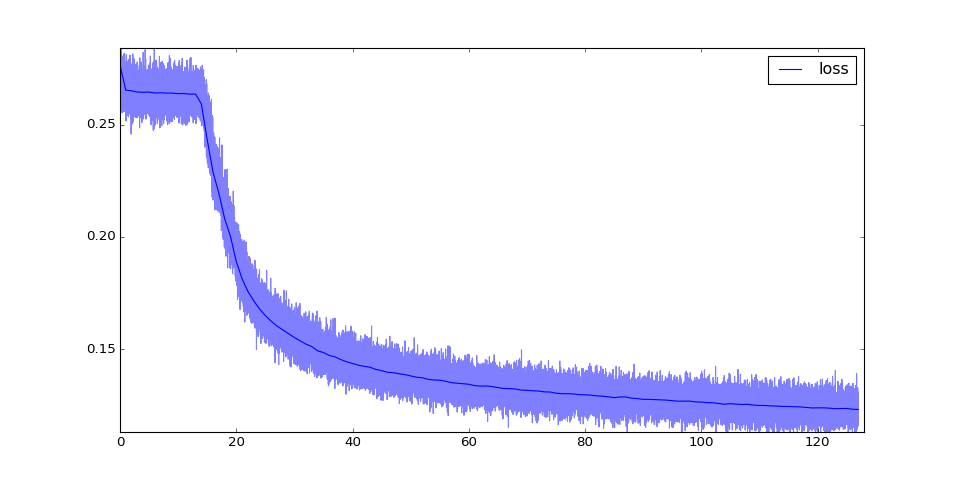

In [10]:
watcher = NNWatcher()
ls = cae.fit(X, n_epoches=128, batch_size=128, loss='log', learning_rate=1.0, watcher=watcher)

cae.save(PATH)

<IPython.core.display.Javascript object>


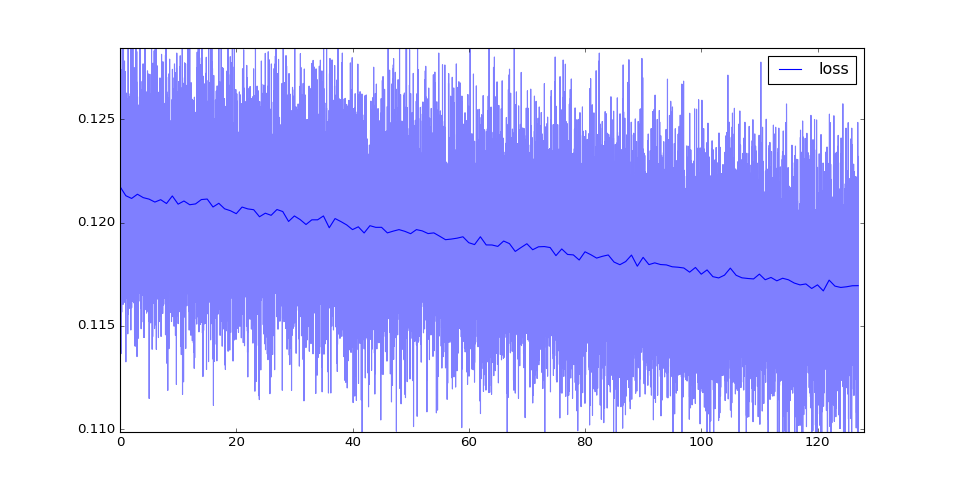

In [14]:
watcher = NNWatcher()
ls = cae.fit(X, n_epoches=128, batch_size=256, loss='log', learning_rate=1.0, watcher=watcher)

cae.save(PATH)

<IPython.core.display.Javascript object>


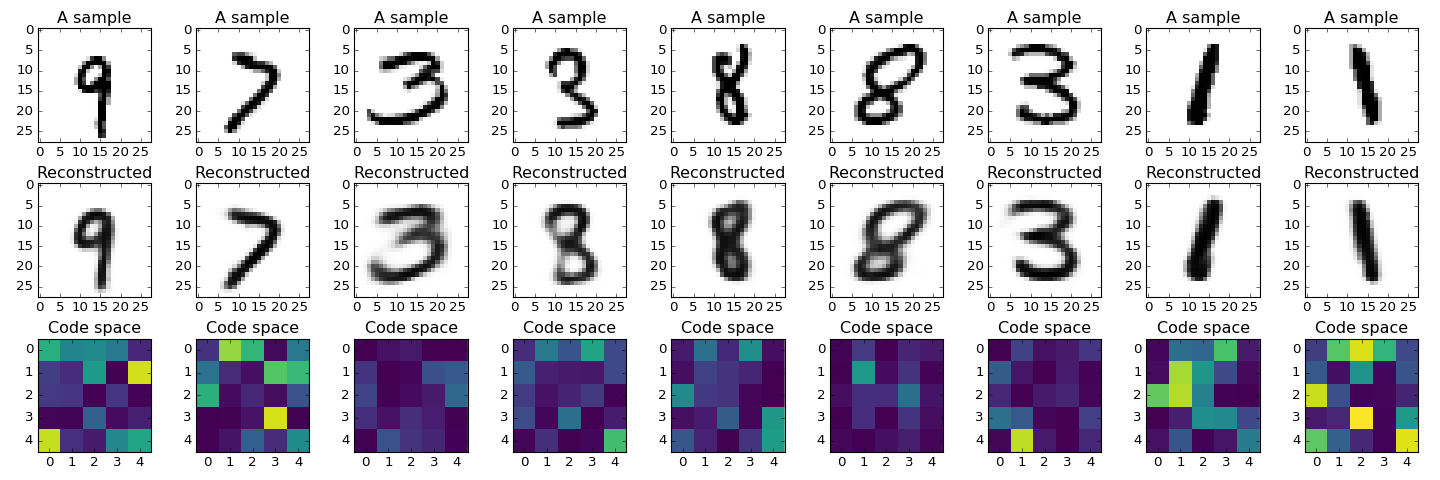

In [15]:
import itertools
n_codes_side = 5
n_codes = 25

nrows, ncols = 1, 9

indx = np.random.choice(X_test.shape[0], size=ncols, replace=False)
codes = cae.encode(X_test[indx])
X_rec = cae.reconstruct(X_test[indx])

fig, ax = plt.subplots(nrows * 3, ncols, figsize=(ncols * 2 , nrows * 6))

for i, j in itertools.product(range(nrows), range(ncols)):
    ax[i * 3, j].imshow(
        X_test[indx[j], 0],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
    )
    ax[i * 3, j].set_title('A sample')
    
    ax[i * 3 + 1, j].imshow(
        X_rec[j, 0],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
    )
    ax[i * 3 + 1, j].set_title('Reconstructed')
    
    
    ax[i * 3 + 2, j].imshow(
        codes[j].reshape(n_codes_side, n_codes_side),
        interpolation='None', cmap=plt.cm.viridis, vmin=0.0, vmax=np.max(codes)
    )
    ax[i * 3 + 2, j].set_title('Code space')

fig.tight_layout()
plt.show()

In [16]:
code_test = cae.encode(X_test)

In [17]:
max_code = np.max(code_test)

<IPython.core.display.Javascript object>


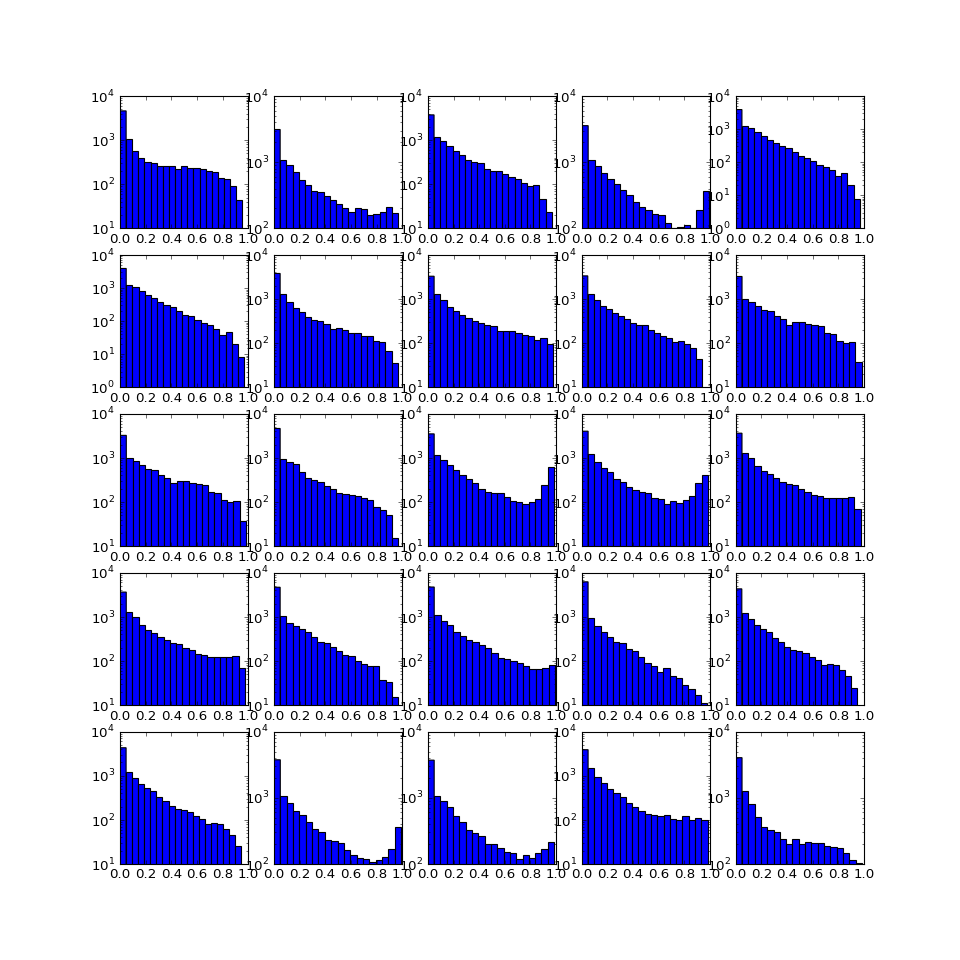

In [18]:
fig, ax = plt.subplots(n_codes_side, n_codes_side, figsize=(12, 12))

for i, j in itertools.product(range(n_codes_side), range(n_codes_side)):
    fn = i * 4 + j
    ax[i, j].hist(code_test[:, fn], bins=20, log=True)

plt.show()

<IPython.core.display.Javascript object>


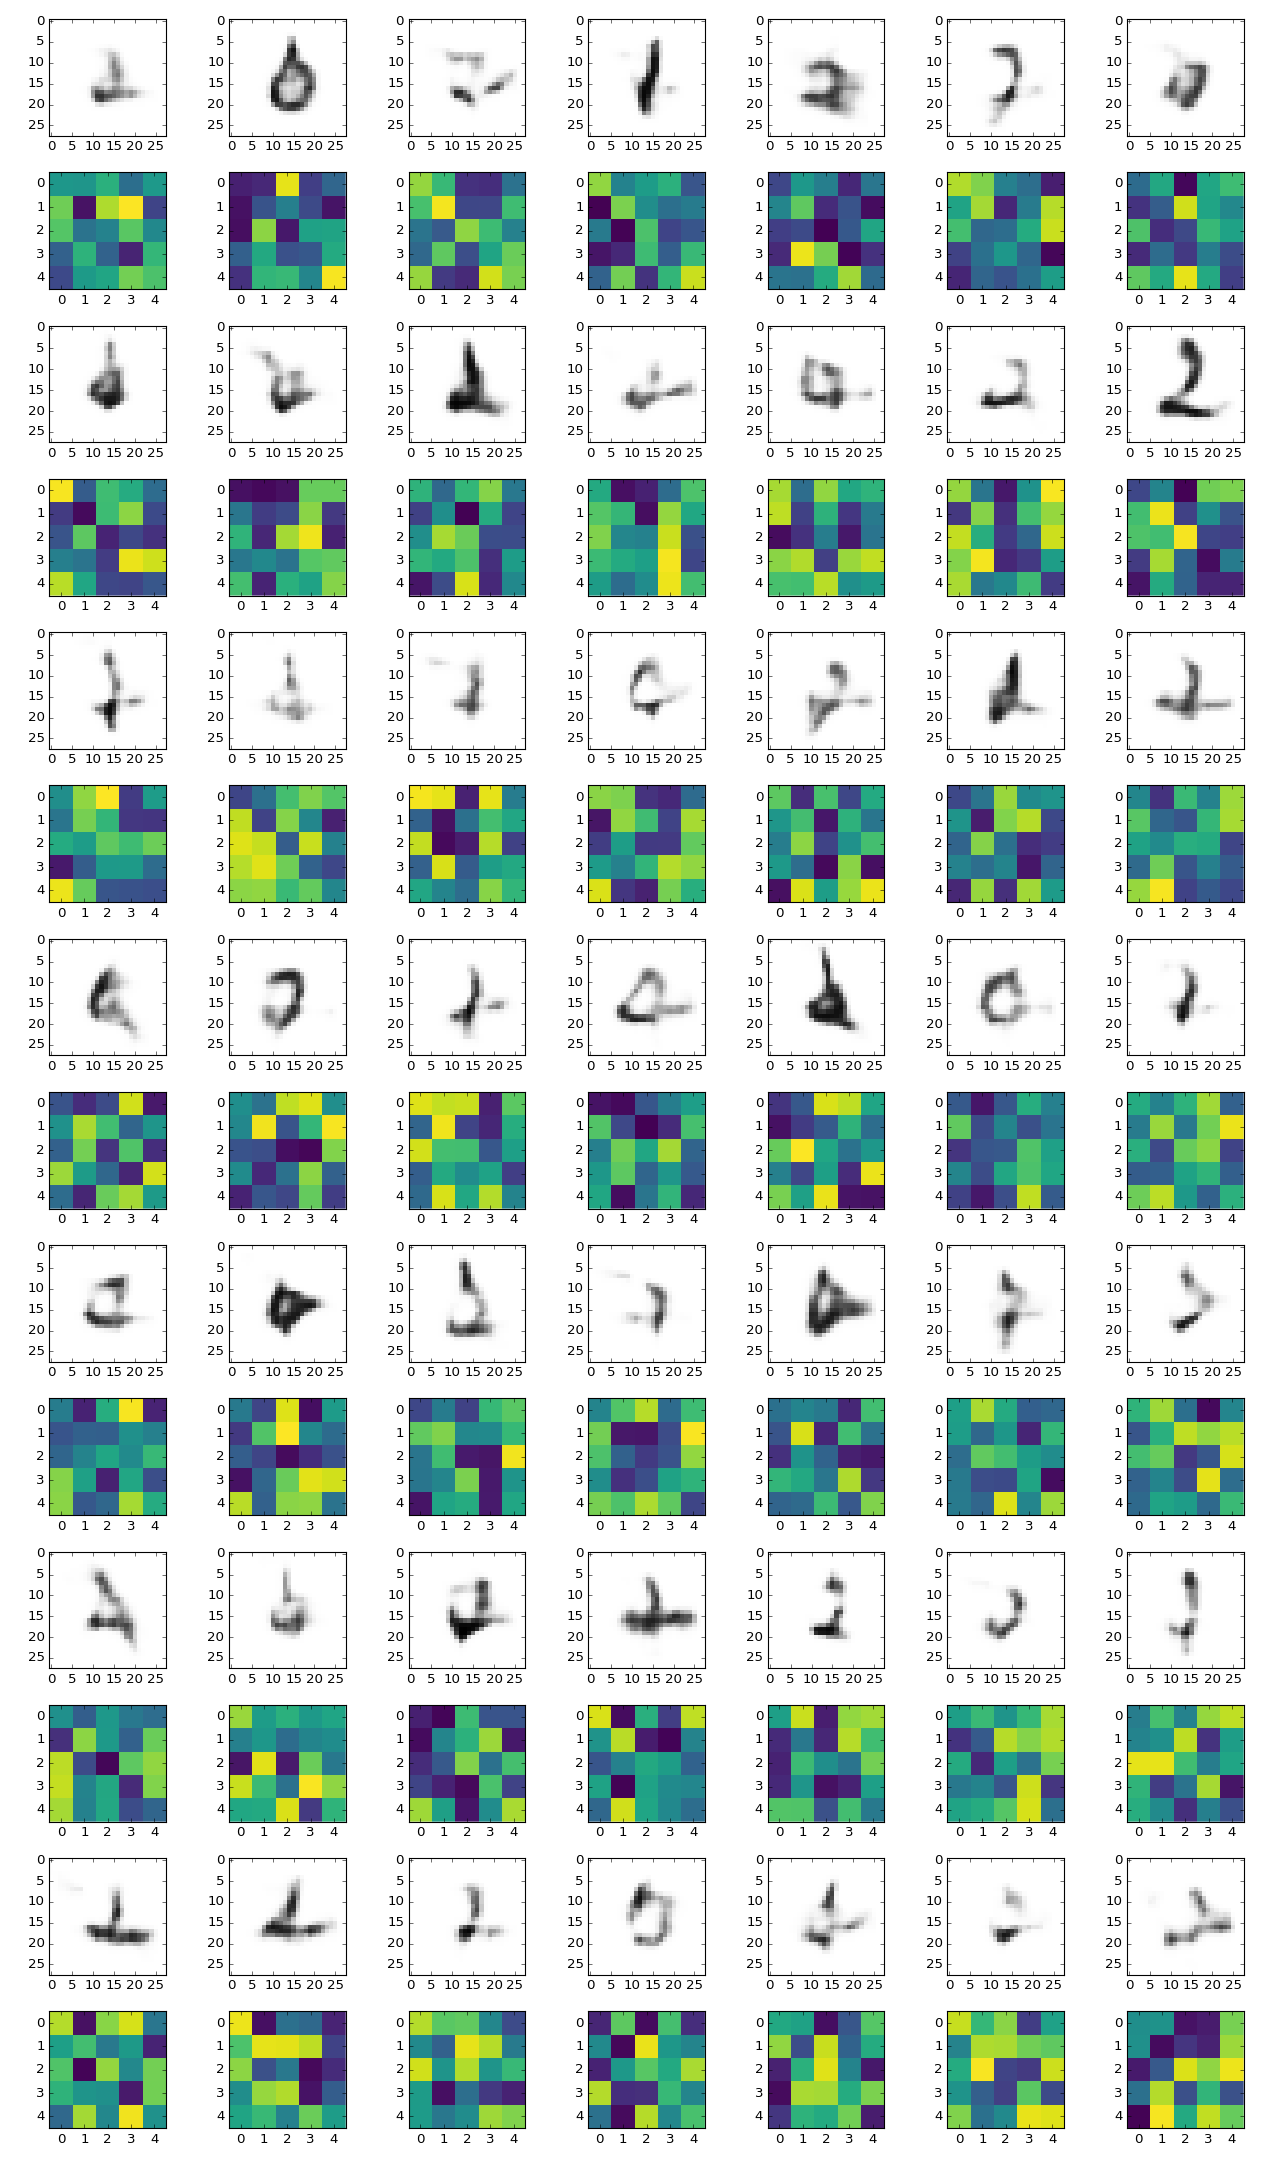

In [20]:
import itertools

nrows, ncols = 7, 7

codes = np.random.uniform(size=(nrows, ncols, n_codes)).astype('float32') * max_code
X_rec = cae.decode(codes.reshape(-1, n_codes)).reshape(nrows, ncols, 28, 28)

fig, ax = plt.subplots(nrows * 2, ncols, figsize=((ncols + 1) * 2, (nrows + 2) * 3))

for i, j in itertools.product(range(nrows), range(ncols)):
    ax[i * 2, j].imshow(
        X_rec[i, j],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
    )
    
    ax[i * 2 + 1, j].imshow(
        codes[i, j].reshape(n_codes_side, n_codes_side),
        interpolation='None', cmap=plt.cm.viridis, vmin=0.0, vmax=max_code
    )

plt.tight_layout()
plt.show()

In [21]:
W1 = layers.get_all_params(cae.net)[0].get_value()

In [22]:
W1.shape

(16, 1, 3, 3)

In [24]:
W1 = W1.reshape(-1, 3, 3)

<IPython.core.display.Javascript object>


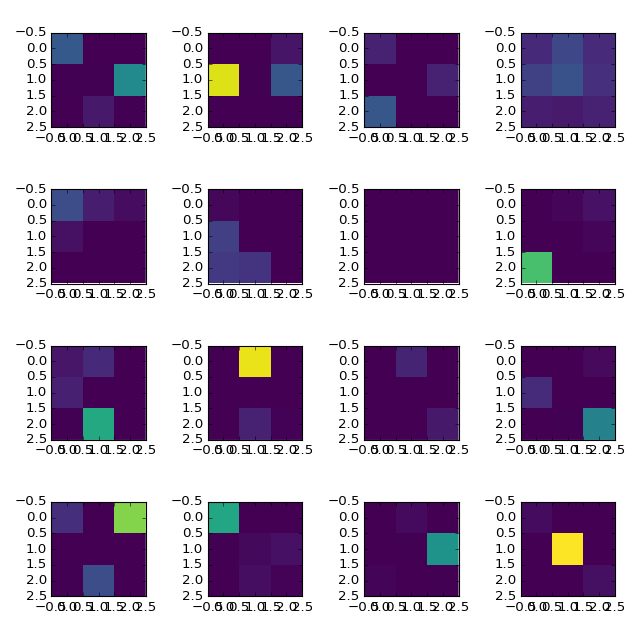

In [25]:
import itertools

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 2 , nrows * 2))

for i, j in itertools.product(range(nrows), range(ncols)):
    k = i * ncols + j
    
    vmin = np.min(np.abs(W1))
    vmax = np.max(np.abs(W1))
    
    ax[i, j].imshow(
        W1[k],
        interpolation='None', cmap=plt.cm.viridis, vmin=vmin, vmax=vmax
    )

#fig.suptitle('Visualization of the first hidden coefficients')
fig.tight_layout()
plt.show()